<a href="https://colab.research.google.com/github/kishoremadhi/kishoremadhi/blob/main/Keras_Fuel_Data_Regression_Rocky.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic regression: Predict fuel efficiency

Source : www.tensorflow.org

Run this NB in colab : Here is the link :  <br />
https://colab.research.google.com/drive/12PQG-nryA7-vMTszFZ95zGuxhv1wKTEn?usp=sharing

In a *regression* problem, the aim is to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where the aim is to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This notebook uses the classic [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) Dataset and builds a model to predict the fuel efficiency of late-1970s and early 1980s automobiles. To do this, provide the model with a description of many automobiles from that time period. This description includes attributes like: cylinders, displacement, horsepower, and weight.

This example uses the `tf.keras` API, see [this guide](https://www.tensorflow.org/guide/keras) for details.

In [21]:
# Use seaborn for pairplot
#!pip install -q seaborn

## -q option means quiet installation

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [23]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.8.0


## The Auto MPG dataset

The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).


### Get the data
First download and import the dataset using pandas:

In [24]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

## comment='\t' if any line starts with tab-space then skip it , don't parse it

In [25]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Clean the data

The dataset contains a few unknown values.

In [26]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [27]:
dataset = dataset.dropna()

The `"Origin"` column is really categorical, not numeric. So convert that to a one-hot with [pd.get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html):


In [28]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [29]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

## prefix=''  -> adds a blank prefix
## other wise we would see Origin_Europe	Origin_Japan	Origin_USA 

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


### Split the data into train and test

Now split the dataset into a training set and a test set.

Use the test set in the final evaluation of our models.

In [30]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

## yes, we could have used the traditional sklearn.model_selection .train_test_split method also.

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

Looking at the top row it should be clear that the fuel efficiency (MPG) is a function of all the other parameters. Looking at the other rows it should be clear that they are functions of each other.

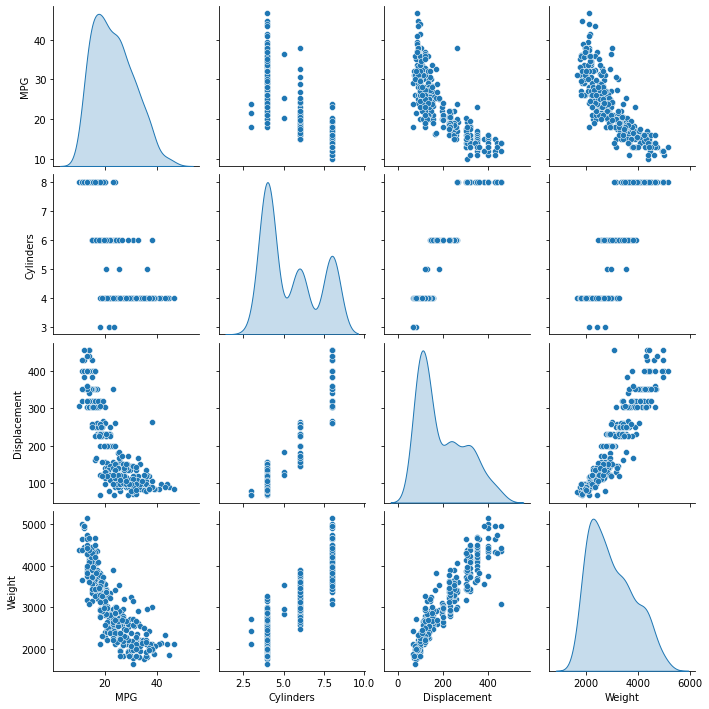

In [31]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

Also look at the overall statistics, note how each feature covers a very different range:

In [32]:
train_dataset.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
count,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000
mean,23.310510,5.477707,195.318471,104.869427,2990.251592,15.559236,75.898089,0.178344,0.197452,0.624204
std,7.728652,1.699788,104.331589,38.096214,843.898596,2.789230,3.675642,0.383413,0.398712,0.485101
min,10.000000,3.000000,68.000000,46.000000,1649.000000,8.000000,70.000000,0.000000,0.000000,0.000000
25%,17.000000,4.000000,105.500000,76.250000,2256.500000,13.800000,73.000000,0.000000,0.000000,0.000000
50%,22.000000,4.000000,151.000000,94.500000,2822.500000,15.500000,76.000000,0.000000,0.000000,1.000000
75%,28.950000,8.000000,265.750000,128.000000,3608.000000,17.200000,79.000000,0.000000,0.000000,1.000000
max,46.600000,8.000000,455.000000,225.000000,5140.000000,24.800000,82.000000,1.000000,1.000000,1.000000


### Split features from labels

Separate the target value, the "label", from the features. This label is the value that you will train the model to predict.

In [33]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')   ## pop()  is to remove
test_labels = test_features.pop('MPG')

train_labels.head()

146    28.0
282    22.3
69     12.0
378    38.0
331    33.8
Name: MPG, dtype: float64

## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are.

In [34]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


It is good practice to normalize features that use different scales and ranges. 

One reason this is important is because the features are multiplied by the model weights. So the scale of the outputs and the scale of the gradients are affected by the scale of the inputs. 

Although a model *might* converge without feature normalization, normalization makes training much more stable. 

### The Normalization layer
The `preprocessing.Normalization` layer is a clean and simple way to build that preprocessing into your model.

The first step is to create the layer:

In [35]:
normalizer = preprocessing.Normalization()

Then `.adapt()` it to the data:

In [36]:
normalizer.adapt(np.array(train_features))

This calculates the mean and variance, and stores them in the layer. 

In [37]:
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


When the layer is called it returns the input data, with each feature independently normalized:

In [38]:
first = np.array(train_features[:1])  ## Just taken the 1st row

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())  ## just normalizing to demonstrate first row

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


## Linear regression

Building a ANN model for a single variable linear regression.

### One Variable

Start with a single-variable linear regression, to predict `MPG` from `Horsepower`.

Training a model with `tf.keras` typically starts by defining the model architecture.

In this case use a `keras.Sequential` model. This model represents a sequence of steps. In this case there are two steps:

* Normalize the input `horsepower`.
* Apply a linear transformation ($y = mx+b$) to produce 1 output using `layers.Dense`.

The number of _inputs_ can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

First create the horsepower `Normalization` layer:

In [40]:
horsepower = train_features['Horsepower']
horsepower_normalizer = preprocessing.Normalization(input_shape=[1,])
horsepower_normalizer.adapt(horsepower)

Build the sequential model:

In [41]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

This model will predict `MPG` from `Horsepower`.

Once the model is built, configure the training procedure using the `Model.compile()` method. The most important arguments to compile are the `loss` and the `optimizer` since these define what will be optimized (`mean_absolute_error`) and how (using the `optimizers.Adam`).

In [64]:
horsepower_model.compile(
  optimizer= tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

print(horsepower_model)

In [65]:
#print(train_features['Horsepower'])
#print(train_labels)

Once the training is configured, use `Model.fit()` to execute the training:

In [66]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

## Elapsed real time, real time, wall-clock time, or wall time is the actual time taken 
## from the start of a computer program to the end.

CPU times: user 3.63 s, sys: 172 ms, total: 3.8 s
Wall time: 5.46 s


In [67]:
print(history.history)   ####  PROBLEM   --> NOT YET DEBUGGED   --> Misbehaving only in Simplilearn Jupyter Labs !!!

{'loss': [22.071664810180664, 21.26983070373535, 20.469497680664062, 19.67086410522461, 18.869848251342773, 18.07225799560547, 17.2687931060791, 16.469436645507812, 15.668898582458496, 14.8685941696167, 14.069337844848633, 13.271909713745117, 12.478062629699707, 11.693594932556152, 10.92125415802002, 10.148199081420898, 9.3626127243042, 8.624670028686523, 7.910788536071777, 7.221213340759277, 6.5864081382751465, 6.000610828399658, 5.469749450683594, 5.060006618499756, 4.730260848999023, 4.475346565246582, 4.283690929412842, 4.128505706787109, 4.019863605499268, 3.9480550289154053, 3.8962061405181885, 3.8555803298950195, 3.838948965072632, 3.825315475463867, 3.8205013275146484, 3.813270330429077, 3.808345317840576, 3.804567337036133, 3.804039478302002, 3.802363395690918, 3.8031699657440186, 3.8034586906433105, 3.8054728507995605, 3.8031225204467773, 3.804814577102661, 3.803741693496704, 3.8056929111480713, 3.8046793937683105, 3.8037984371185303, 3.8059356212615967, 3.803906202316284, 3.

Visualize the model's training progress using the stats stored in the `history` object.

In [68]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

## No accuracy as this is regression problem

,loss,val_loss,epoch
0,22.071665,22.142546,0
1,21.269831,21.342611,1
2,20.469498,20.542690,2
3,19.670864,19.742458,3
4,18.869848,18.942616,4


In [69]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

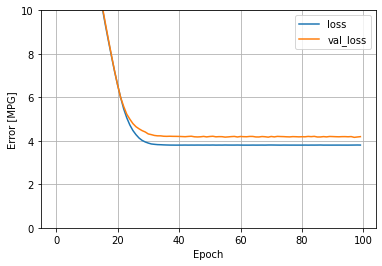

In [70]:
plot_loss(history)

Collect the results on the test set, for later:

In [71]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=2)

3/3 - 0s - loss: 3.6492 - 19ms/epoch - 6ms/step


Since this is a single variable regression it's easy to look at the model's predictions as a function of the input:

In [72]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

In [73]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

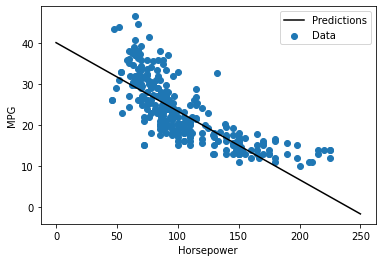

In [74]:
plot_horsepower(x,y)

### Multiple inputs

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same $y = mx+b$ except that $m$ is a matrix and $b$ is a vector.

This time use the `Normalization` layer that was adapted to the whole dataset.

In [75]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

When you call this model on a batch of inputs, it produces `units=1` outputs for each example.

In [76]:
linear_model.predict(train_features[:20])

array([[ 0.354],
       [ 0.616],
       [-1.34 ],
       [ 1.151],
       [ 0.076],
       [ 0.156],
       [ 0.2  ],
       [ 1.171],
       [-0.32 ],
       [-0.564],
       [ 1.136],
       [-0.872],
       [ 0.549],
       [-1.482],
       [-0.539],
       [ 0.019],
       [ 1.159],
       [-1.191],
       [ 0.908],
       [ 0.811]], dtype=float32)

When you call the model it's weight matrices will be built. Now you can see that the `kernel` (the m in y=mx+b) has a shape of `(9,1)`.

In [77]:
linear_model.layers[1].kernel   ## as their are 9 features

<tf.Variable 'dense_3/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.48 ],
       [ 0.544],
       [ 0.172],
       [-0.746],
       [ 0.142],
       [ 0.35 ],
       [ 0.155],
       [-0.485],
       [-0.1  ]], dtype=float32)>

Use the same `compile` and `fit` calls as for the single input `horsepower` model:

In [78]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [79]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 3.54 s, sys: 208 ms, total: 3.75 s
Wall time: 3.36 s


Using all the inputs achieves a much lower training and validation error than the `horsepower` model: 

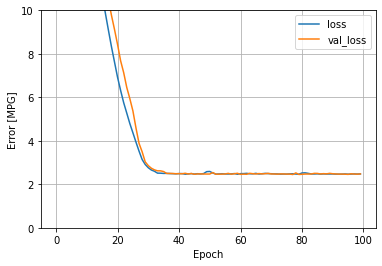

In [80]:
plot_loss(history)

Collect the results on the test set, for later:

In [81]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=2)

3/3 - 0s - loss: 2.5069 - 19ms/epoch - 6ms/step


## A DNN regression

The previous section implemented linear models for single and multiple inputs.

This section implements single-input and multiple-input DNN models. The code is basically the same except the model is expanded to include some "hidden"  non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer.
* Two hidden, nonlinear, `Dense` layers using the `relu` nonlinearity.
* A linear single-output layer.

Both will use the same training procedure so the `compile` method is included in the `build_and_compile_model` function below.

In [82]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### One variable

Start with a DNN model for a single input: "Horsepower"

In [83]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

This model has quite a few more trainable parameters than the linear models.

In [84]:
##dnn_horsepower_model.summary()

Train the model:

In [85]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 3.87 s, sys: 210 ms, total: 4.08 s
Wall time: 5.53 s


This model does slightly better than the linear-horsepower model.

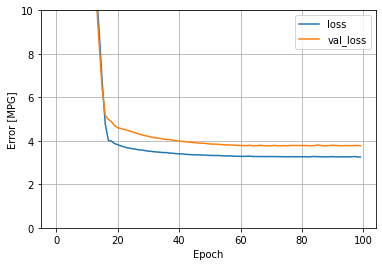

In [86]:
plot_loss(history)

If you plot the predictions as a function of `Horsepower`, you'll see how this model takes advantage of the nonlinearity provided by the hidden layers:

In [87]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

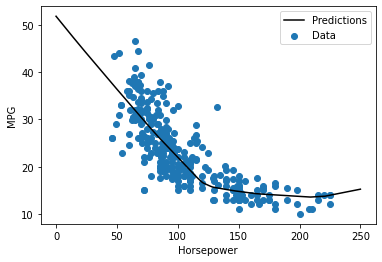

In [88]:
plot_horsepower(x, y)

Collect the results on the test set, for later:

In [90]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=2)

3/3 - 0s - loss: 2.9106 - 39ms/epoch - 13ms/step


### Full model

If you repeat this process using all the inputs it slightly improves the performance on the validation dataset.

In [94]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 9)                19        
 ion)                                                            
                                                                 
 dense_7 (Dense)             (None, 64)                640       
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [95]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 4.53 s, sys: 215 ms, total: 4.74 s
Wall time: 4.43 s


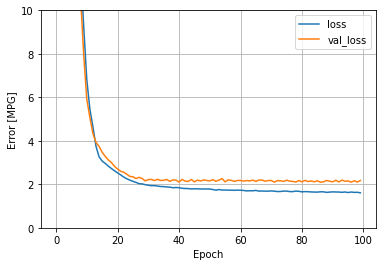

In [96]:
plot_loss(history)

Collect the results on the test set:

In [97]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=2)

3/3 - 0s - loss: 1.6804 - 51ms/epoch - 17ms/step


## Performance

Now that all the models are trained check the test-set performance and see how they did:

In [98]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.649158
linear_model,2.506947
dnn_horsepower_model,2.910642
dnn_model,1.680423


These results match the validation error seen during training.

### Make predictions

Finally, predict to have a look at the errors made by the model when making predictions on the test set:

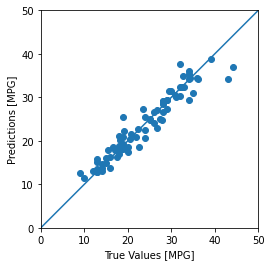

In [99]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


It looks like the model predicts reasonably well. 

Now take a look at the error distribution:

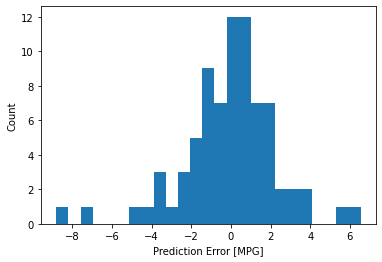

In [100]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

If you're happy with the model save it for later use:

In [101]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


If you reload the model, it gives identical output:

In [102]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [103]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.649158
linear_model,2.506947
dnn_horsepower_model,2.910642
dnn_model,1.680423
reloaded,1.680423


## Conclusion

This notebook introduced a few techniques to handle a regression problem. Here are a few more tips that may help:

* [Mean Squared Error (MSE)](https://www.tensorflow.org/api_docs/python/tf/losses/MeanSquaredError) and [Mean Absolute Error (MAE)](https://www.tensorflow.org/api_docs/python/tf/losses/MeanAbsoluteError) are common loss functions used for regression problems. Mean Absolute Error is less sensitive to outliers. Different loss functions are used for classification problems.
* Similarly, evaluation metrics used for regression differ from classification.
* When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
* Overfitting is a common problem for DNN models, it wasn't a problem for this case.
